In [215]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from slugify import slugify
import ast
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import booleanize

In [2]:
artists_df = pd.read_csv("data/artists.csv", keep_default_na=False)
tracks_df = pd.read_csv("data/tracks.csv")
playlists_df = pd.read_csv("data/playlists.csv")

artists_df.set_index("id", inplace=True)
tracks_df.set_index("slug", inplace=True)
playlists_df.set_index("slug", inplace=True)


In [3]:
print(len(artists_df) - len(artists_df.dropna()))
print(len(tracks_df) - len(tracks_df.dropna()))
print(len(playlists_df) - len(playlists_df.dropna()))

0
1
0


In [4]:
tracks_df.dropna(inplace=True)
playlists_df[playlists_df.index != "4lPN1fB7XWJr5xAVWbbHY2"]
artists_df.name = artists_df.name.str.strip()

In [5]:
playlists_df["log_followers"] = np.log10(1+playlists_df.followers)

In [6]:
print("min track [s] = ", tracks_df.duration_ms.min() / 1000)
print("max track [h] = ", tracks_df.duration_ms.max() / 1000 / 60 / 60)


min track [s] =  1.831
max track [h] =  3.0


In [7]:
for playlist_column in playlists_df.columns:
    assert len(artists_df[artists_df.name == playlist_column]) == 0

In [8]:
tracks_df["track_artists"] = list(
    map(
        lambda track_artists: list(
            map(int,ast.literal_eval(track_artists))
        ),
        tracks_df["track_artists"].values
    )
)

In [9]:
playlists_df["playlist_tracks"] = list(
    map(
        ast.literal_eval,
        playlists_df["playlist_tracks"].values
    )
)

In [11]:
playlists_artists = []

for playlist in tqdm(playlists_df.itertuples()):
    playlists_artists.append([])
    playlist_tracks_df = tracks_df.loc[playlist.playlist_tracks].dropna()
    
    for track in playlist_tracks_df.itertuples():
        track_artists_df = artists_df.loc[track.track_artists]     
        track_artists = sorted(track_artists_df.name.to_list())
        playlists_artists[-1].extend(track_artists)
    
playlists_df["playlist_artists"] = playlists_artists
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


In [31]:
playlists_df["playlist_artists"]

slug
7jvfS7fn7qx2HS3oMklAdw    [Lefa, Vald, Bon Entendeur, Isabelle Pierre, C...
4IgAuc1ur86KtYZAEnD6Q3    [Talkdemonic, Lymbyc Systym, Lymbyc Systym, Ly...
4LMlI2WnTGDqtKU8bTNGFS    [RAM, Armin van Buuren, Jennifer Rene, Chicane...
4g4D9ayX9v2YWVx1ciKMFh    [PLÜM, Chelsea Cutler, Jeremy Zucker, filous, ...
21iTXBzTLFliu8uQT6Espl    [Rameses B, Phaera, TheFatRat, L'Indécis, Andr...
                                                ...                        
5rLHlv0Avd3mgbNmMDOnXv    [Dance With the Dead, Scandroid, JAY Z, Linkin...
1p5ZeMzXpkEHYuM8zy2j3e    [Sabaton, Black Sabbath, Rammstein, Powerwolf,...
7DiLUwsIPRhAwEiVnCu7oU    [FM Attack, Bryce Vine, Falling In Reverse, Ou...
1eUtArGA9QdSphQLArbvF6    [Imagine Dragons, Imagine Dragons, Adam Gontie...
2Ytz7ABT8ffnQHo5frgSpq    [Peggy Gou, ANNA, Jon Hopkins, Peggy Gou, Pegg...
Name: playlist_artists, Length: 8970, dtype: object

In [20]:
len(playlists_df[np.array(list(map(len,map(np.unique,playlists_df["playlist_artists"])))) < 3])


142

In [22]:
from collections import Counter

In [32]:

artist_counter = Counter([item for sublist in playlists_artists for item in sublist])

len(
    Counter(el for el in artist_counter.elements() if artist_counter[el] < 5 )
)

71247

In [157]:
ii = list(np.unique(sorted([*list(map(int,map(round,np.logspace(0,4,71)))), *list(range(35,45)), *list(range(25,35))])))
yy = []

artist_counter = Counter(
    [item for sublist in playlists_artists for item in np.unique(sublist)]
)

for hh,jj in enumerate(ii):
    kk = len(
        Counter(el for el in artist_counter.elements() if artist_counter[el] >= jj )
    )
    
    if kk == 0:
        ii = ii[:hh]
        break
    else:
        yy.append(kk)
    

[30, 4804]


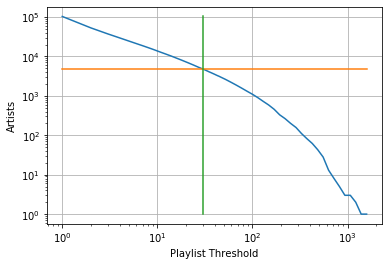

In [160]:
plt.plot(ii,yy)
# for zz in range(1,6):
#     plt.plot([0,4000],[zz*1000,zz*1000],label=str(zz*1000))
# plt.ylim(0,1.15*np.max(yy))

chosen_value = 30

for xx in range(len(ii)):
    if ii[xx] >= chosen_value: break
    
print([ii[xx],yy[xx]])
plt.plot([np.min(ii),np.max(ii)],[yy[xx], yy[xx]])
plt.plot([ii[xx], ii[xx]],[np.min(yy),np.max(yy)])

plt.xscale('log')
plt.yscale('log')
plt.ylabel("Artists")
plt.xlabel("Playlist Threshold")
plt.grid(True)

In [193]:
len(['name',
 'init_year',
 'last_year',
 'followers',
 'is_coding',
 'is_programming',
 'playlist_tracks',
 'log_followers',
 'playlist_artists',
 'artist_counters'])

10

In [172]:
playlists_df["artist_counters"] = list(
    map(Counter, playlists_df.playlist_artists)
)


In [175]:
for cur_key in Counter(el for el in artist_counter.elements() if artist_counter[el] >= chosen_value ).keys():
    cur_vec = list(map(
        lambda cur_counter: cur_counter[cur_key], 
        playlists_df.artist_counters
    ))

    playlists_df[cur_key] = cur_vec
    

In [199]:
bad_playlists = []

for playlist in tqdm(playlists_df.itertuples()):
    max_val = np.max(playlist[11:])
    cur_sum = np.sum(playlist[11:])
    
    if cur_sum < 3 or cur_sum == max_val :
        bad_playlists.append(playlist[0])
        
print(len(bad_playlists))
    


457


In [234]:
playlists_df = playlists_df[~playlists_df.index.isin(bad_playlists)]

booleanize.unbooleanize(playlists_df)

playlists_df["norm_followers"] = list(map(int,map(round,playlists_df.log_followers / 1.25)))

cur_data = playlists_df[
    [
        'is_coding',
        'is_programming',
        'norm_followers',
        *playlists_df.columns[10:-1]
    ]
]

In [220]:
playlists_df.to_pickle("playlist")

,name,init_year,last_year,followers,is_coding,is_programming,playlist_tracks,log_followers,playlist_artists,artist_counters,...,DJ Antoine,Compuphonic,John Adams,Opia,Kings of Convenience,YUNGBLUD,Manatee Commune,Cigarettes After Sex,Modjo,The Cars
slug,,,,,,,,,,,,,,,,,,,,,
7jvfS7fn7qx2HS3oMklAdw,FCKNYE Festival | Lyon's lauradubarry Weekly b...,2019,2019,0,0,1,"[65hdAdd1skq94ecWH4vfJI, 0xh5kFdNkx6h7K1z7XpDq...",0.000000,"[Lefa, Vald, Bon Entendeur, Isabelle Pierre, C...","{'Lefa': 1, 'Vald': 1, 'Bon Entendeur': 1, 'Is...",...,0,0,0,0,0,0,0,0,0,0
4IgAuc1ur86KtYZAEnD6Q3,Chill Beats and Coding,2018,2019,10,1,0,"[0ftLDutf9cdHvGjZBxHZoE, 0zZIYr7bxWx4RMQx5k4R3...",1.041393,"[Talkdemonic, Lymbyc Systym, Lymbyc Systym, Ly...","{'Talkdemonic': 1, 'Lymbyc Systym': 3, 'The Bo...",...,0,0,0,0,0,0,0,0,0,0
4LMlI2WnTGDqtKU8bTNGFS,For coding,2016,2019,0,1,0,"[1dsCnboVpNoYfkbbr2EaoB, 7KXoG5CPXtt4n0oiY4gPt...",0.000000,"[RAM, Armin van Buuren, Jennifer Rene, Chicane...","{'RAM': 1, 'Armin van Buuren': 2, 'Jennifer Re...",...,0,0,0,0,0,0,0,0,0,0
4g4D9ayX9v2YWVx1ciKMFh,Coding,2019,2019,0,1,0,"[3nKxX6zfFneRwrQtC8mshP, 3PMsgFdVtCeTgjzE8X9TT...",0.000000,"[PLÜM, Chelsea Cutler, Jeremy Zucker, filous, ...","{'PLÜM': 1, 'Chelsea Cutler': 1, 'Jeremy Zucke...",...,0,0,0,0,0,0,0,0,0,0
21iTXBzTLFliu8uQT6Espl,Programming,2019,2019,0,0,1,"[5ZBemWNJFt6Ne1ay2vjVJD, 4bTpPZDWettH15QgNgRWr...",0.000000,"[Rameses B, Phaera, TheFatRat, L'Indécis, Andr...","{'Rameses B': 1, 'Phaera': 1, 'TheFatRat': 1, ...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rLHlv0Avd3mgbNmMDOnXv,Coding,2015,2019,0,1,0,"[44K1GCbNLf1NHlCaLaYONk, 65eohvrL4ttjA7EfFkQOh...",0.000000,"[Dance With the Dead, Scandroid, JAY Z, Linkin...","{'Dance With the Dead': 1, 'Scandroid': 1, 'JA...",...,0,0,0,0,0,0,0,0,0,0
1p5ZeMzXpkEHYuM8zy2j3e,metal coding,2018,2019,0,1,0,"[5jJ7sOjvPrFDXOZbeXsVxa, 1Y373MqadDRtclJNdnUXV...",0.000000,"[Sabaton, Black Sabbath, Rammstein, Powerwolf,...","{'Sabaton': 1, 'Black Sabbath': 1, 'Rammstein'...",...,0,0,0,0,0,0,0,0,0,0
7DiLUwsIPRhAwEiVnCu7oU,Coding/Programming/Hacking,2019,2019,1,1,1,"[1V0bJe9zMshw82p3Hfu1cj, 51723ybY4gFTaLXZKaq1z...",0.301030,"[FM Attack, Bryce Vine, Falling In Reverse, Ou...","{'FM Attack': 1, 'Bryce Vine': 1, 'Falling In ...",...,0,0,0,0,0,0,0,0,0,0


In [247]:
playlists_df[[*playlists_df.columns[0:10], "norm_followers"]].to_pickle("playlists_lookup.pkl")

In [251]:
artists_df.to_pickle("artists_lookup.pkl")

In [253]:
tracks_df.to_pickle("tracks_lookup.pkl")